## Analyze Residual Orbital Effects at Pseudo-invriant calibration sites (PICS)
### Jianing Fang (jf3423@columbia.edu)

In [8]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress

In [9]:
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 8
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [10]:
def get_file_list(product_dir):
    filelist=[]
    for year in sorted(os.listdir(product_dir)):
        for year_file in sorted(os.listdir(os.path.join(product_dir, year))):
            filelist.append(os.path.join(product_dir, year, year_file))
    return filelist

In [11]:
LCSIF_DIR="../../data/processed/LCSIF_v1"
LCREF_DIR="LCSIF_reflectance_v1"

LCSIF_FILE_LIST=get_file_list(LCSIF_DIR)
LCREF_FILE_LIST=get_file_list(LCREF_DIR)

LCSIF_AVHRR_PERIOD_FILE_LIST=LCSIF_FILE_LIST[0:19*24]
LCSIF_MODIS_PERIOD_FILE_LIST=LCSIF_FILE_LIST[19*24:]

LCREF_AVHRR_PERIOD_FILE_LIST=LCREF_FILE_LIST[0:19*24]
LCREF_MODIS_PERIOD_FILE_LIST=LCREF_FILE_LIST[19*24:]

In [12]:
CSIF_DIR="/CSIF_v2/"
SIF_AVHRR_V4_SIF_MODIS_DIFF_DIR="../../data/processed/AVHRR_MODIS_SIF_DIFF/"
fig_dir="./figs/"
VECTOR_DIR="../../data/vector/"
MAX_PROCESSES=8

In [13]:
PICS=pd.read_csv(os.path.join(VECTOR_DIR, "PICS.csv"))
PICS_2=pd.read_csv(os.path.join(VECTOR_DIR, "PICS_2.csv"))

In [14]:
PICS=pd.concat([PICS, PICS_2]).reset_index().drop(["index"], axis=1)

In [15]:
def extract_sif_pics_site(file_list):
    pics_sif_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).sif_clear_daily
        pics_sif_list.append(np.diag(ds.sel(latitude=PICS.lat, longitude=PICS.lon, method="nearest")[0].values))
        ds.close()
    return pics_sif_list

def extract_nir_pics_site(file_list):
    pics_nir_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).nir
        pics_nir_list.append(np.diag(ds.sel(latitude=PICS.lat, longitude=PICS.lon, method="nearest")[0].values))
        ds.close()
    return pics_nir_list

def extract_red_pics_site(file_list):
    pics_red_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).red
        pics_red_list.append(np.diag(ds.sel(latitude=PICS.lat, longitude=PICS.lon, method="nearest")[0].values))
        ds.close()
    return pics_red_list

In [16]:
PICS_LCSIF_AVHRR_PERIOD = extract_sif_pics_site(LCSIF_AVHRR_PERIOD_FILE_LIST)
PICS_LCSIF_MODIS_PERIOD = extract_sif_pics_site(LCSIF_MODIS_PERIOD_FILE_LIST)

PICS_RED_AVHRR_PERIOD = extract_red_pics_site(LCREF_AVHRR_PERIOD_FILE_LIST)
PICS_RED_MODIS_PERIOD = extract_red_pics_site(LCREF_MODIS_PERIOD_FILE_LIST)

PICS_NIR_AVHRR_PERIOD = extract_nir_pics_site(LCREF_AVHRR_PERIOD_FILE_LIST)
PICS_NIR_MODIS_PERIOD = extract_nir_pics_site(LCREF_MODIS_PERIOD_FILE_LIST)

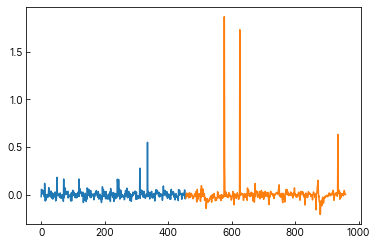

In [17]:
avhrr_period_idx=np.arange(0, len(PICS_RED_AVHRR_PERIOD))
modis_period_idx=np.arange(len(PICS_RED_AVHRR_PERIOD), len(PICS_RED_AVHRR_PERIOD) + len(PICS_RED_MODIS_PERIOD))
pics_red_avhrr_matrix = np.vstack(PICS_RED_AVHRR_PERIOD)
pics_red_modis_matrix = np.vstack(PICS_RED_MODIS_PERIOD)


pics_red_avhrr_mean = np.mean(pics_red_avhrr_matrix, axis=0)
pics_red_avhrr_normalized= pics_red_avhrr_matrix / pics_red_avhrr_mean

pics_red_modis_mean = np.mean(pics_red_modis_matrix, axis=0)
pics_red_modis_normalized= pics_red_modis_matrix / pics_red_modis_mean

pics_red_avhrr_normalized_detrend = detrend(pics_red_avhrr_normalized, axis=0)
pics_red_modis_normalized_detrend = detrend(pics_red_modis_normalized, axis=0)

plt.plot(avhrr_period_idx, pics_red_avhrr_normalized_detrend[:, -3])
plt.plot(modis_period_idx, pics_red_modis_normalized_detrend[:, -3])

In [18]:
pics_red_avhrr_site_sesonality_amplitude=np.zeros(len(PICS))
for i in range(len(PICS)):
    pics_red_avhrr_site_sesonality=pics_red_avhrr_normalized_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_red_avhrr_site_sesonality_amplitude[i]=np.max(pics_red_avhrr_site_sesonality)-np.min(pics_red_avhrr_site_sesonality)

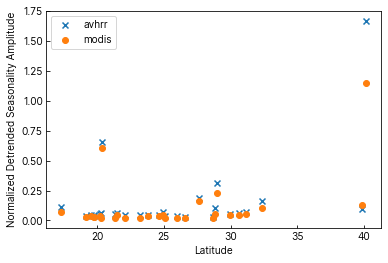

In [19]:
pics_red_modis_site_sesonality_amplitude=np.zeros(len(PICS))

for i in range(len(PICS)):
    pics_red_modis_site_sesonality=pics_red_modis_normalized_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_red_modis_site_sesonality_amplitude[i]=np.max(pics_red_modis_site_sesonality)-np.min(pics_red_modis_site_sesonality)
plt.scatter(np.abs(PICS.lat), pics_red_avhrr_site_sesonality_amplitude, label="avhrr", marker="x")
plt.scatter(np.abs(PICS.lat), pics_red_modis_site_sesonality_amplitude, label="modis", marker="o")
plt.ylabel("Normalized Detrended Seasonality Amplitude")
plt.xlabel("Latitude")
plt.legend(loc="upper left")

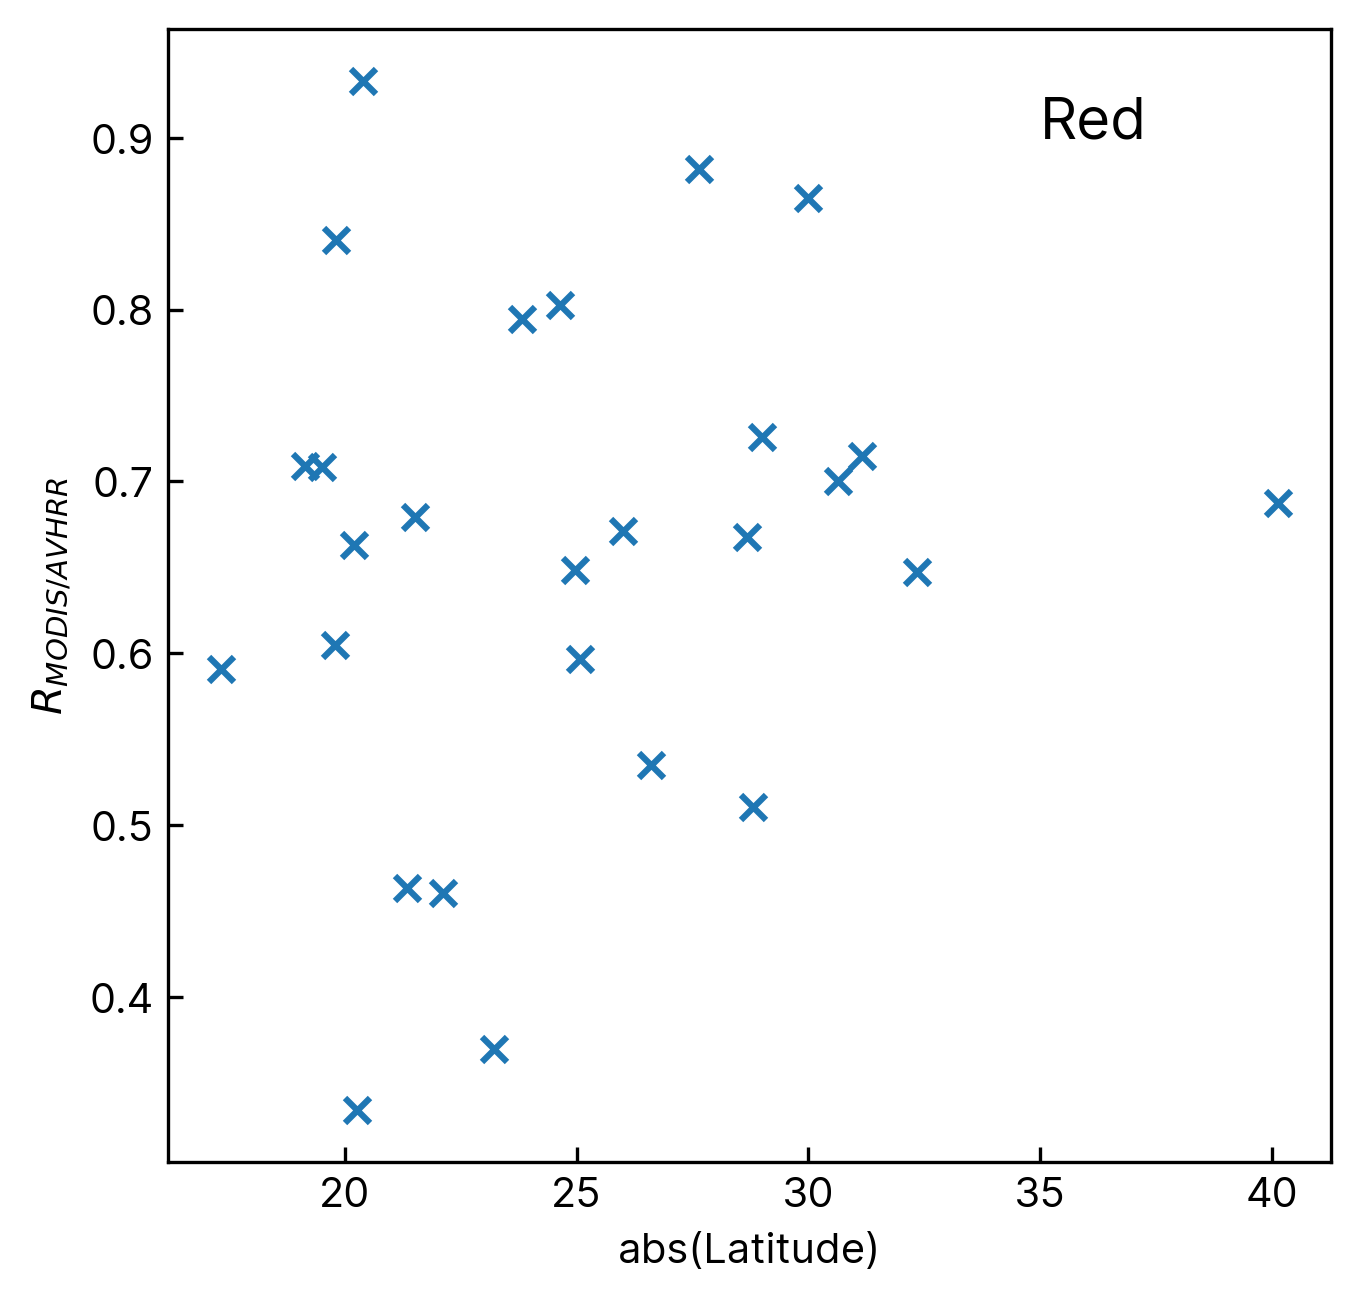

In [20]:
plt.figure(figsize=(5,5), dpi=300)
sel=np.delete(np.arange(0,28), -3)
plt.scatter(np.abs(PICS.lat)[sel], (pics_red_modis_site_sesonality_amplitude/pics_red_avhrr_site_sesonality_amplitude)[sel], marker="x")
plt.ylabel("$R_{MODIS/AVHRR}$")
plt.text(35, 0.9, "Red", fontsize=14)
plt.xlabel("abs(Latitude)")
plt.savefig("./figs/Red_R_MODIS-AVHRR_nan_mean.png")

In [21]:
linregress(np.abs(PICS.lat)[sel], (pics_red_modis_site_sesonality_amplitude/pics_red_avhrr_site_sesonality_amplitude)[sel])

LinregressResult(slope=0.0044069538685254026, intercept=0.5494544468498491, rvalue=0.15593271159002164, pvalue=0.4373480984894712, stderr=0.0055832372229725254, intercept_stderr=0.14231513730916023)

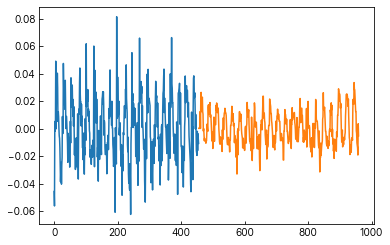

In [22]:
avhrr_period_idx=np.arange(0, len(PICS_NIR_AVHRR_PERIOD))
modis_period_idx=np.arange(len(PICS_NIR_AVHRR_PERIOD), len(PICS_NIR_AVHRR_PERIOD) + len(PICS_NIR_MODIS_PERIOD))
pics_nir_avhrr_matrix = np.vstack(PICS_NIR_AVHRR_PERIOD)
pics_nir_modis_matrix = np.vstack(PICS_NIR_MODIS_PERIOD)


pics_nir_avhrr_mean = np.mean(pics_nir_avhrr_matrix, axis=0)
pics_nir_avhrr_normalized= pics_nir_avhrr_matrix / pics_nir_avhrr_mean

pics_nir_modis_mean = np.mean(pics_nir_modis_matrix, axis=0)
pics_nir_modis_normalized= pics_nir_modis_matrix / pics_nir_modis_mean

pics_nir_avhrr_normalized_detrend = detrend(pics_nir_avhrr_normalized, axis=0)
pics_nir_modis_normalized_detrend = detrend(pics_nir_modis_normalized, axis=0)

plt.plot(avhrr_period_idx, pics_nir_avhrr_normalized_detrend[:, 4])
plt.plot(modis_period_idx, pics_nir_modis_normalized_detrend[:, 4])

In [23]:
pics_nir_avhrr_site_sesonality_amplitude=np.zeros(len(PICS))
for i in range(len(PICS)):
    pics_nir_avhrr_site_sesonality=pics_nir_avhrr_normalized_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_nir_avhrr_site_sesonality_amplitude[i]=np.max(pics_nir_avhrr_site_sesonality)-np.min(pics_nir_avhrr_site_sesonality)

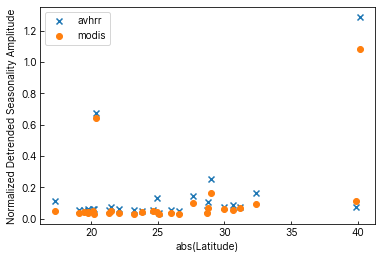

In [24]:
pics_nir_modis_site_sesonality_amplitude=np.zeros(len(PICS))

for i in range(len(PICS)):
    pics_nir_modis_site_sesonality=pics_nir_modis_normalized_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_nir_modis_site_sesonality_amplitude[i]=np.max(pics_nir_modis_site_sesonality)-np.min(pics_nir_modis_site_sesonality)
plt.scatter(np.abs(PICS.lat), pics_nir_avhrr_site_sesonality_amplitude, label="avhrr", marker="x")
plt.scatter(np.abs(PICS.lat), pics_nir_modis_site_sesonality_amplitude, label="modis", marker="o")
plt.ylabel("Normalized Detrended Seasonality Amplitude")
plt.xlabel("abs(Latitude)")
plt.legend(loc="upper left")


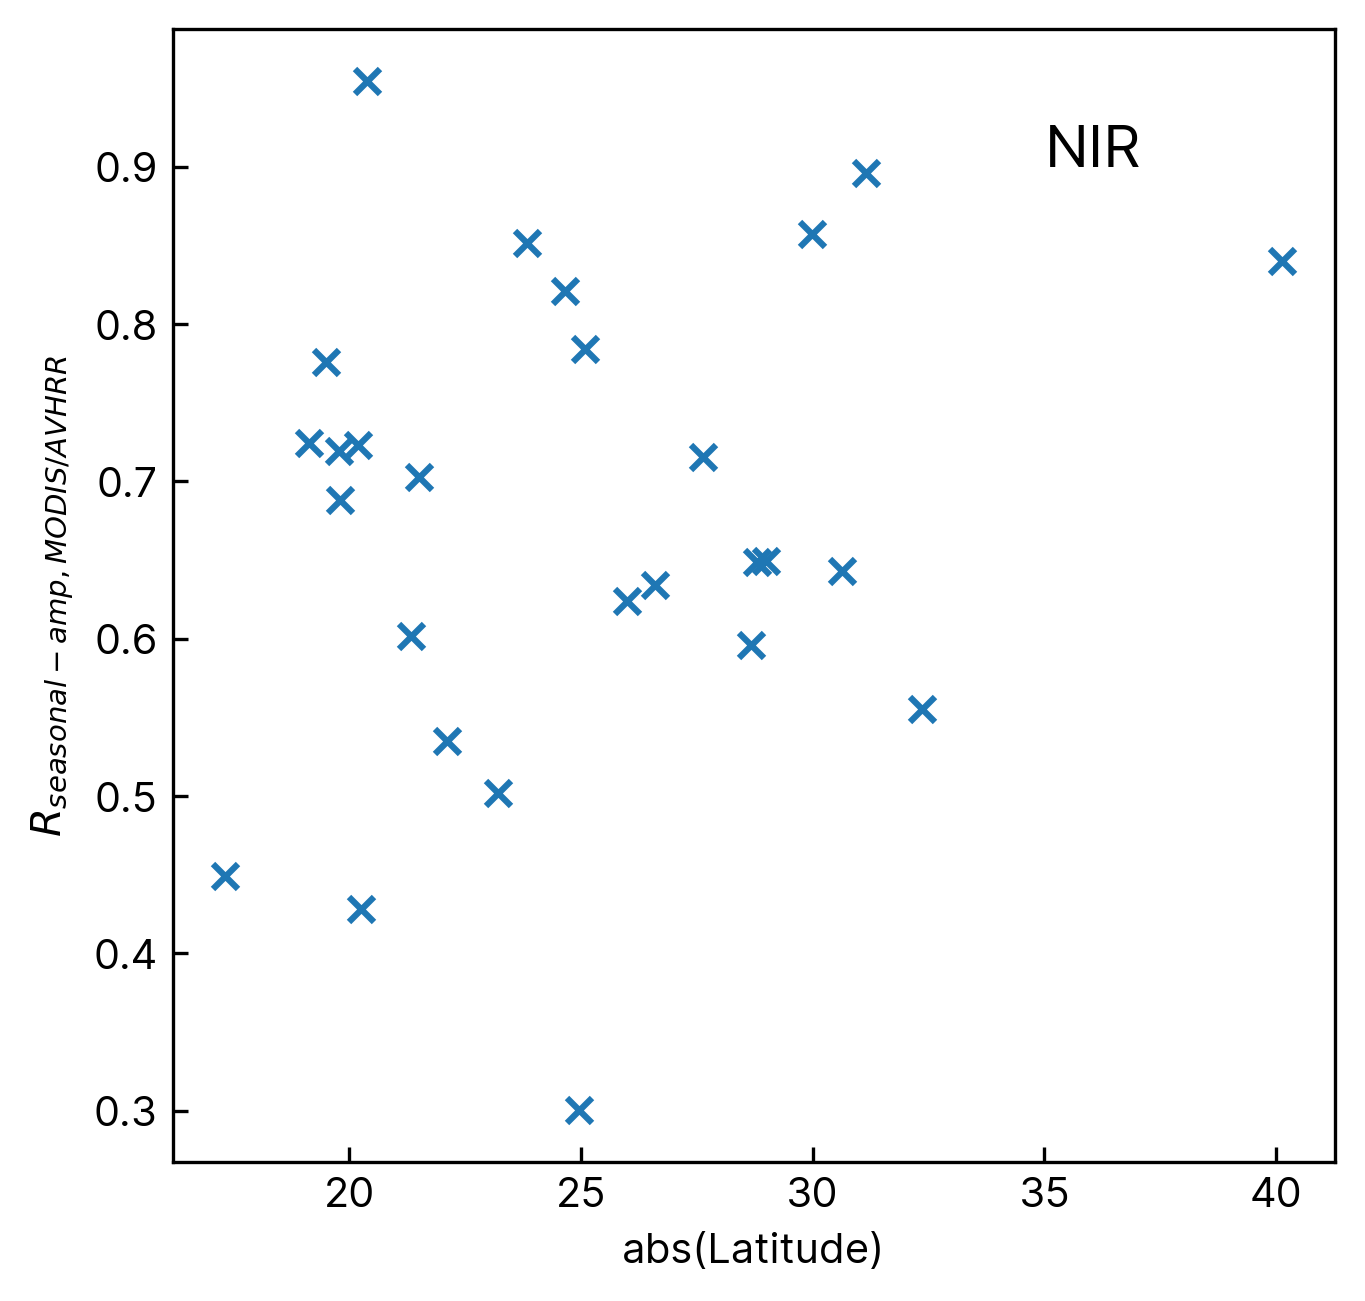

In [25]:
sel=np.delete(np.arange(0,28), -3)
plt.figure(figsize=(5,5), dpi=300)
plt.scatter(np.abs(PICS.lat)[sel], (pics_nir_modis_site_sesonality_amplitude/pics_nir_avhrr_site_sesonality_amplitude)[sel], marker="x")
plt.ylabel("$R_{seasonal-amp, MODIS/AVHRR}$")
plt.text(35, 0.9, "NIR", fontsize=14)
plt.xlabel("abs(Latitude)")
plt.savefig("./figs/NIR_R_MODIS-AVHRR_nan_mean.png")

In [26]:
linregress(np.abs(PICS.lat)[sel], (pics_nir_modis_site_sesonality_amplitude/pics_nir_avhrr_site_sesonality_amplitude)[sel])

LinregressResult(slope=0.005730248967982, intercept=0.5317683286564906, rvalue=0.19689141562462298, pvalue=0.3249449703159534, stderr=0.005706781121241918, intercept_stderr=0.1454642363253322)

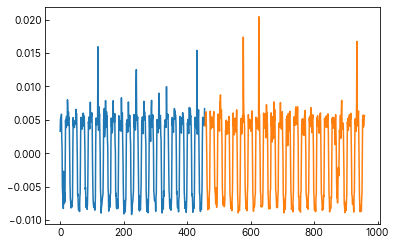

In [27]:
avhrr_period_idx=np.arange(0, len(PICS_LCSIF_AVHRR_PERIOD))
modis_period_idx=np.arange(len(PICS_LCSIF_AVHRR_PERIOD), len(PICS_LCSIF_AVHRR_PERIOD) + len(PICS_LCSIF_MODIS_PERIOD))
pics_lcsif_avhrr_matrix = np.vstack(PICS_LCSIF_AVHRR_PERIOD)
pics_lcsif_modis_matrix = np.vstack(PICS_LCSIF_MODIS_PERIOD)


pics_lcsif_avhrr_mean = np.mean(pics_lcsif_avhrr_matrix, axis=0)
pics_lcsif_avhrr_normalized= pics_lcsif_avhrr_matrix / pics_lcsif_avhrr_mean

pics_lcsif_modis_mean = np.mean(pics_lcsif_modis_matrix, axis=0)
pics_lcsif_modis_normalized= pics_lcsif_modis_matrix / pics_lcsif_modis_mean

pics_lcsif_avhrr_normalized_detrend = detrend(pics_lcsif_avhrr_normalized, axis=0)
pics_lcsif_modis_normalized_detrend = detrend(pics_lcsif_modis_normalized, axis=0)

pics_lcsif_avhrr_detrend = detrend(pics_lcsif_avhrr_matrix, axis=0)
pics_lcsif_modis_detrend = detrend(pics_lcsif_modis_matrix, axis=0)

plt.plot(avhrr_period_idx, pics_lcsif_avhrr_detrend[:, -3])
plt.plot(modis_period_idx, pics_lcsif_modis_detrend[:, -3])

In [28]:
pics_lcsif_avhrr_site_sesonality_amplitude=np.zeros(len(PICS))
for i in range(len(PICS)):
    pics_lcsif_avhrr_site_sesonality=pics_lcsif_avhrr_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_lcsif_avhrr_site_sesonality_amplitude[i]=np.max(pics_lcsif_avhrr_site_sesonality)-np.min(pics_lcsif_avhrr_site_sesonality)

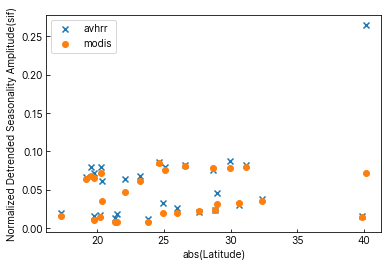

In [29]:
pics_lcsif_modis_site_sesonality_amplitude=np.zeros(len(PICS))

for i in range(len(PICS)):
    pics_lcsif_modis_site_sesonality=pics_lcsif_modis_detrend[:, i].reshape(-1, 24).mean(axis=0)
    pics_lcsif_modis_site_sesonality_amplitude[i]=np.max(pics_lcsif_modis_site_sesonality)-np.min(pics_lcsif_modis_site_sesonality)
plt.scatter(np.abs(PICS.lat), pics_lcsif_avhrr_site_sesonality_amplitude, label="avhrr", marker="x")
plt.scatter(np.abs(PICS.lat), pics_lcsif_modis_site_sesonality_amplitude, label="modis", marker="o")
plt.ylabel("Normalized Detrended Seasonality Amplitude(sif)")
plt.xlabel("abs(Latitude)")
plt.legend(loc="upper left")


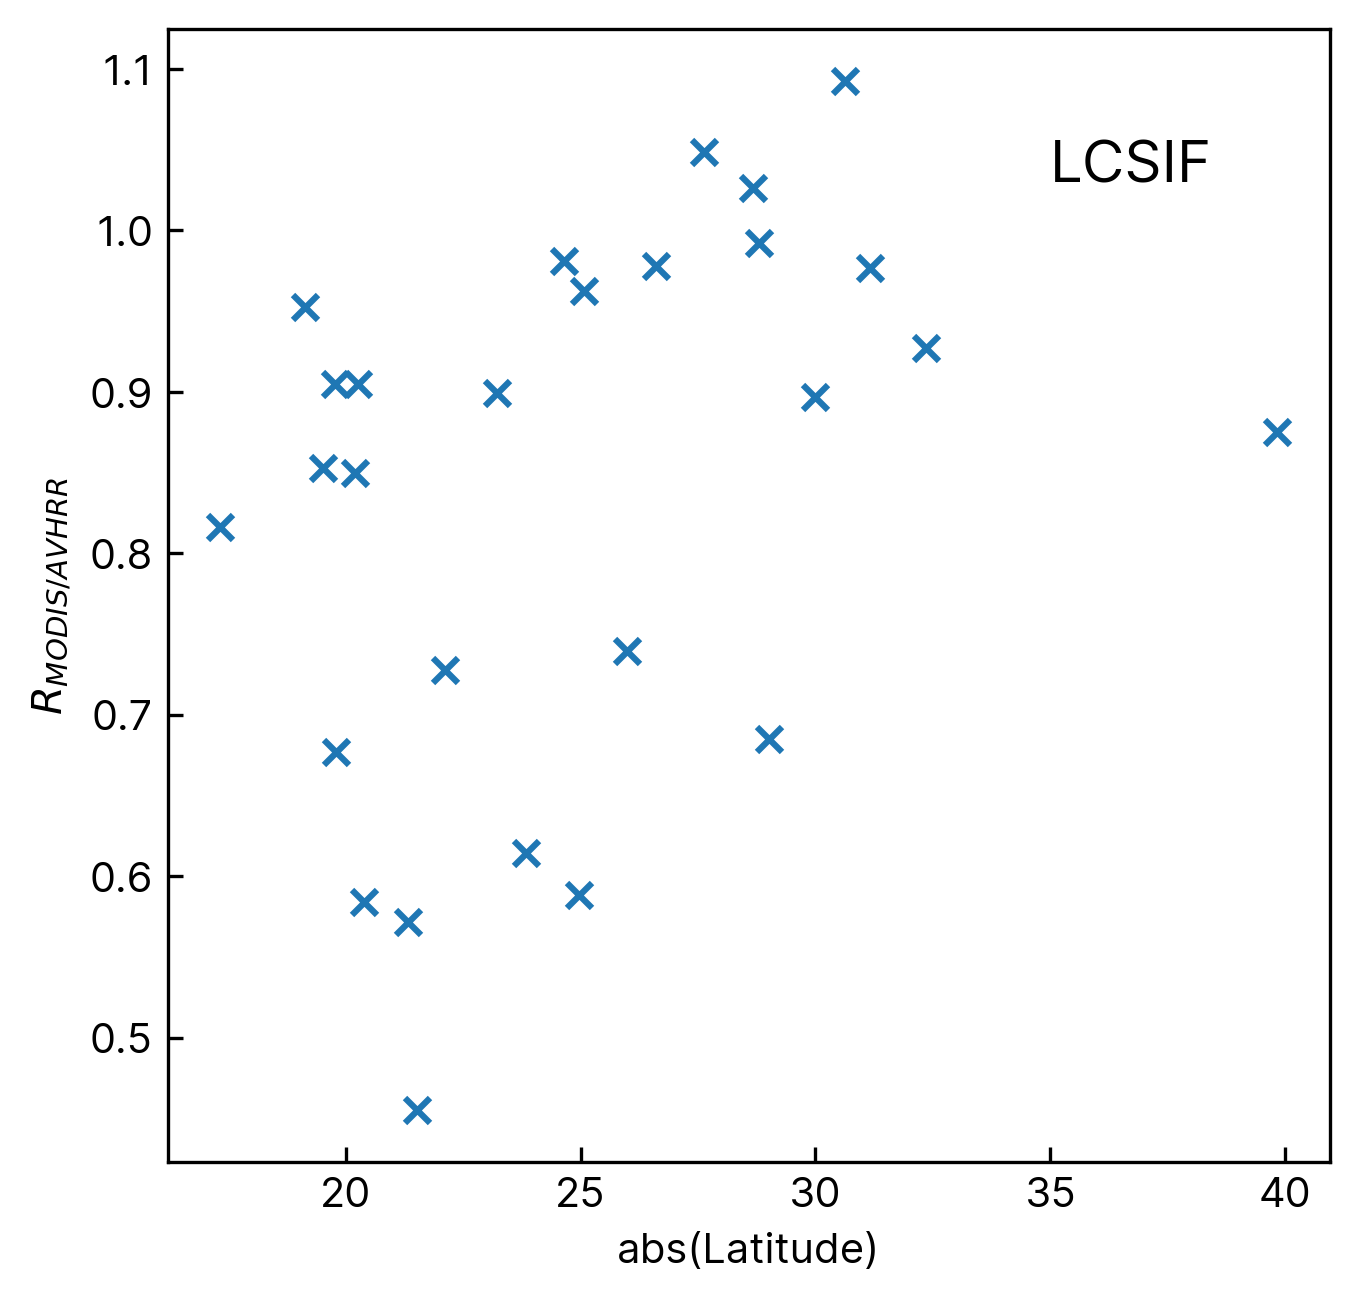

In [30]:
sel=np.delete(np.arange(0,28), -1)
plt.figure(figsize=(5,5), dpi=300)
plt.scatter(np.abs(PICS.lat)[sel], (pics_lcsif_modis_site_sesonality_amplitude/pics_lcsif_avhrr_site_sesonality_amplitude)[sel], marker="x")
plt.ylabel("$R_{MODIS/AVHRR}$")
plt.text(35, 1.03, "LCSIF", fontsize=14)
plt.xlabel("abs(Latitude)")
plt.savefig("./figs/LCSIF_R_MODIS-AVHRR_nan_mean.png")

In [31]:
linregress(np.abs(PICS.lat)[sel], (pics_lcsif_modis_site_sesonality_amplitude/pics_lcsif_avhrr_site_sesonality_amplitude)[sel])


LinregressResult(slope=0.01216242806945671, intercept=0.5327369283495487, rvalue=0.3736240868568644, pvalue=0.05489305431566151, stderr=0.006039025829268101, intercept_stderr=0.15382777877274412)

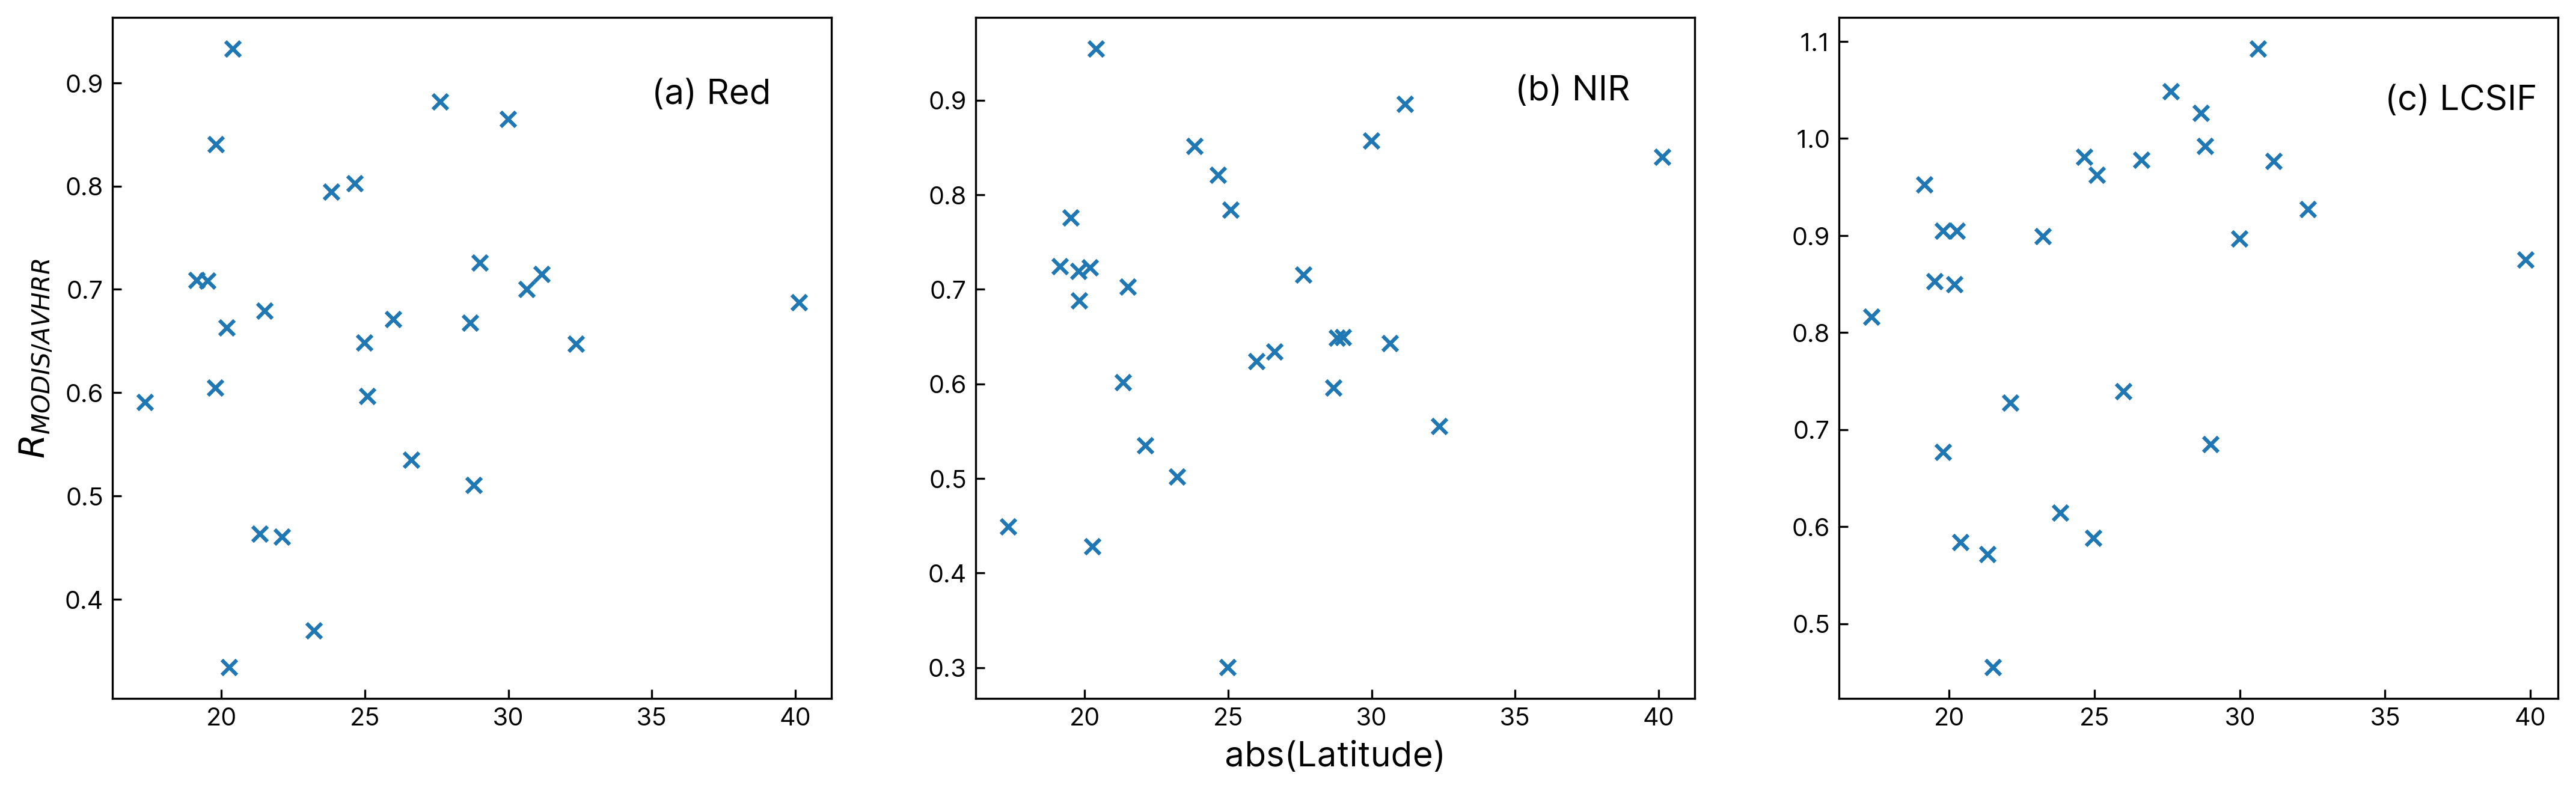

In [32]:
fig, axs = plt.subplots(1,3, figsize=(17.5,5), dpi=300)
ax=axs.flatten()

sel=np.delete(np.arange(0,28), -3)
ax[0].scatter(np.abs(PICS.lat)[sel], (pics_red_modis_site_sesonality_amplitude/pics_red_avhrr_site_sesonality_amplitude)[sel], marker="x")
ax[0].set_ylabel("$R_{MODIS/AVHRR}$", fontsize=14)
ax[0].text(35, 0.88, "(a) Red", fontsize=14)

sel=np.delete(np.arange(0,28), -3)
ax[1].scatter(np.abs(PICS.lat)[sel], (pics_nir_modis_site_sesonality_amplitude/pics_nir_avhrr_site_sesonality_amplitude)[sel], marker="x")
ax[1].text(35, 0.9, "(b) NIR", fontsize=14)
ax[1].set_xlabel("abs(Latitude)", fontsize=14)

sel=np.delete(np.arange(0,28), -1)
ax[2].scatter(np.abs(PICS.lat)[sel], (pics_lcsif_modis_site_sesonality_amplitude/pics_lcsif_avhrr_site_sesonality_amplitude)[sel], marker="x")
ax[2].text(35, 1.03, "(c) LCSIF", fontsize=14)

plt.savefig("./figs/R_MODIS-AVHRR_nan_mean.png")

In [33]:
pics_sif=pics_lcsif_avhrr_matrix[:, 0:20]
pics_nir=pics_nir_avhrr_matrix[:, 0:20]
pics_red=pics_red_avhrr_matrix[:, 0:20]


pics_modis_sif=pics_lcsif_modis_matrix[:, 0:20]
pics_modis_nir=pics_nir_modis_matrix[:, 0:20]
pics_modis_red=pics_red_modis_matrix[:, 0:20]

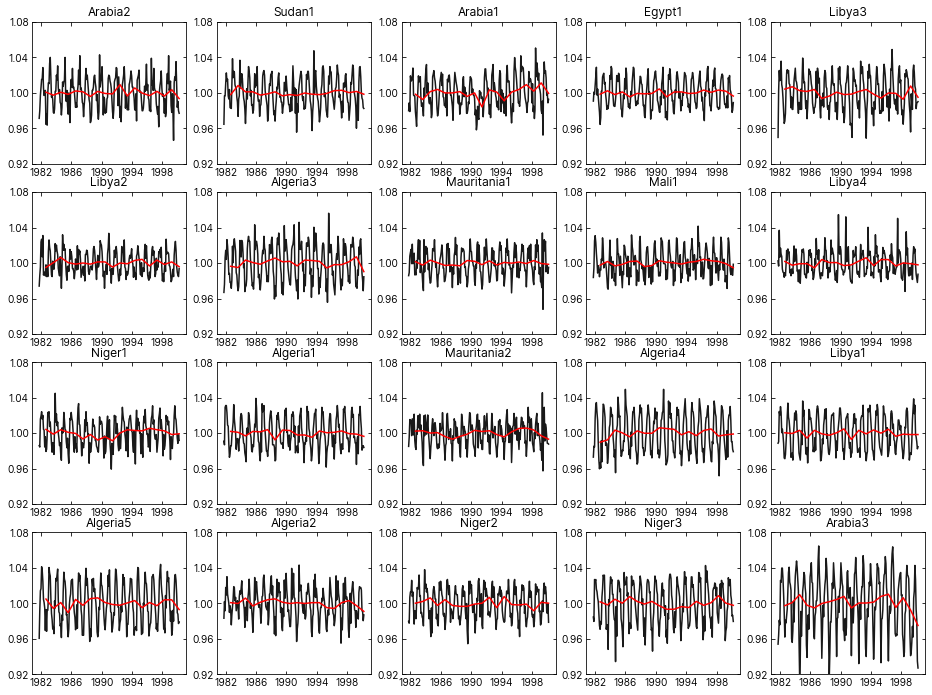

In [34]:
pics_nir_mvc=np.zeros((np.int64(pics_nir.shape[0]/2), pics_nir.shape[1]))
for i in range(int(pics_nir.shape[0]/2)):
    pics_nir_mvc[i, :] = np.nanmean(pics_nir[2*i:2*i+2, :], axis=0)
pics_nir_mvc_year=np.zeros((np.int64(pics_nir_mvc.shape[0] /12), pics_nir_mvc.shape[1]))
for i in range(int(pics_nir_mvc_year.shape[0])):
    pics_nir_mvc_year[i, :] = np.median(pics_nir_mvc[12*i:12*i+12, :], axis=0)

pics_nir_mvc_year_normalized=pics_nir_mvc_year/np.mean(pics_nir_mvc_year, axis=0)
pics_nir_mvc_normalized=pics_nir_mvc/np.mean(pics_nir_mvc, axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

ax=axs.flatten()
for i in range(pics_nir_mvc_year_normalized.shape[1]):
    n_months = pics_nir_mvc_normalized.shape[0]
    n_years = pics_nir_mvc_year_normalized.shape[0]
    ax[i].plot(pd.date_range("1982-1-1", periods=n_months, freq="M"), pics_nir_mvc_normalized[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("1982-1-1", periods=n_years, freq="Y"), pics_nir_mvc_year_normalized[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(0.92, 1.08)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "Normalized_NIR_PICS_avhrr_nir_modvalml_filled_nan_mean.pdf"))


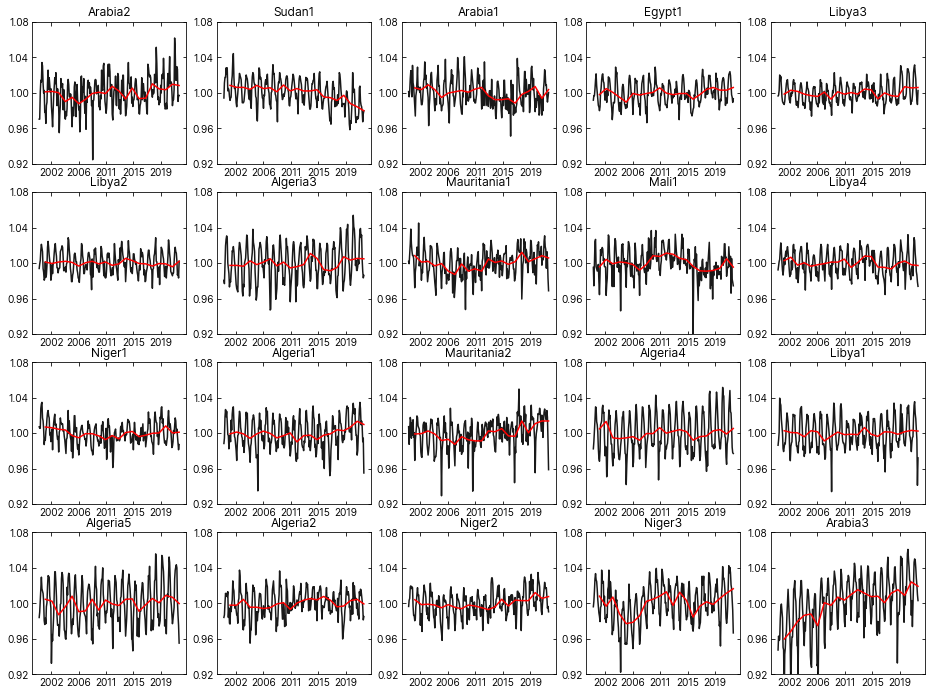

In [35]:
pics_modis_nir_mvc=np.zeros((np.int64(pics_modis_nir.shape[0]/2), pics_modis_nir.shape[1]))
for i in range(int(pics_modis_nir.shape[0]/2)):
    pics_modis_nir_mvc[i, :] = np.nanmean(pics_modis_nir[2*i:2*i+2, :], axis=0)
pics_modis_nir_mvc_year=np.zeros((np.int64(pics_modis_nir_mvc.shape[0] /12), pics_modis_nir_mvc.shape[1]))
for i in range(int(pics_modis_nir_mvc_year.shape[0])):
    pics_modis_nir_mvc_year[i, :] = np.median(pics_modis_nir_mvc[12*i:12*i+12, :], axis=0)

pics_modis_nir_mvc_year_normalized=pics_modis_nir_mvc_year/np.mean(pics_modis_nir_mvc_year, axis=0)
pics_modis_nir_mvc_normalized=pics_modis_nir_mvc/np.mean(pics_modis_nir_mvc, axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

ax=axs.flatten()
for i in range(pics_modis_nir_mvc_year_normalized.shape[1]):
    n_months = pics_modis_nir_mvc_normalized.shape[0]
    n_years = pics_modis_nir_mvc_year_normalized.shape[0]
    ax[i].plot(pd.date_range("2001-1-1", periods=n_months, freq="M"), pics_modis_nir_mvc_normalized[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("2001-1-1", periods=n_years, freq="Y"), pics_modis_nir_mvc_year_normalized[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(0.92, 1.08)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "Normalized_modis_nir_PICS_modis_nir_modvalml_filled_nan_mean.pdf"))


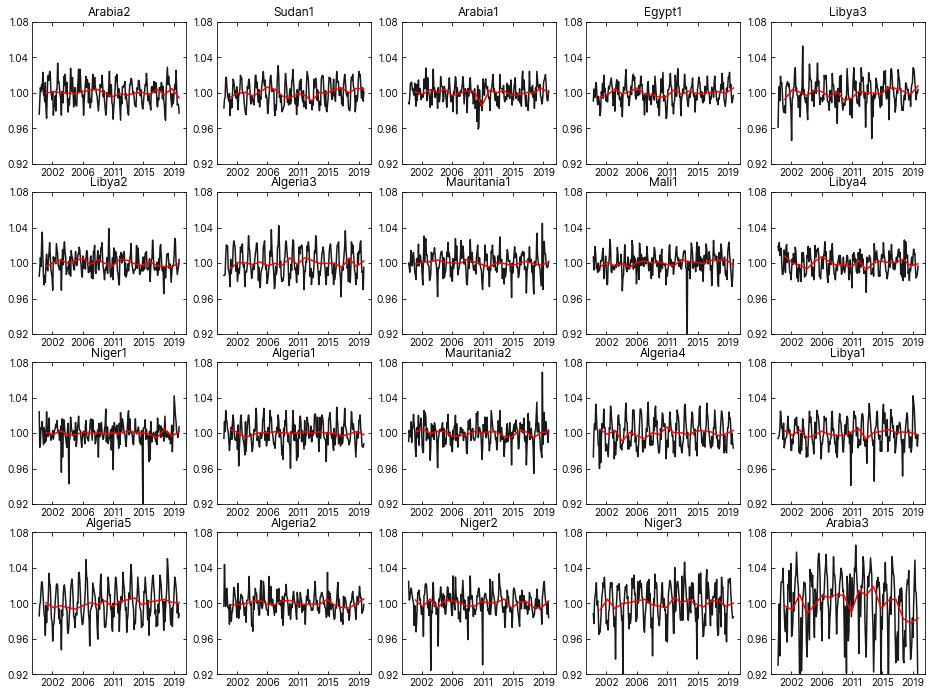

In [36]:
pics_red_mvc=np.zeros((np.int64(pics_red.shape[0]/2), pics_red.shape[1]))
for i in range(int(pics_red.shape[0]/2)):
    pics_red_mvc[i, :] = np.nanmean(pics_red[2*i:2*i+2, :], axis=0)
pics_red_mvc_year=np.zeros((np.int64(pics_red_mvc.shape[0] /12), pics_red_mvc.shape[1]))
for i in range(int(pics_red_mvc_year.shape[0])):
    pics_red_mvc_year[i, :] = np.median(pics_red_mvc[12*i:12*i+12, :], axis=0)

pics_red_mvc_year_normalized=pics_red_mvc_year/np.mean(pics_red_mvc_year, axis=0)
pics_red_mvc_normalized=pics_red_mvc/np.mean(pics_red_mvc, axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

ax=axs.flatten()
for i in range(pics_red_mvc_year_normalized.shape[1]):
    n_months = pics_red_mvc_normalized.shape[0]
    n_years = pics_red_mvc_year_normalized.shape[0]
    ax[i].plot(pd.date_range("2001-1-1", periods=n_months, freq="M"), pics_red_mvc_normalized[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("2001-1-1", periods=n_years, freq="Y"), pics_red_mvc_year_normalized[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(0.92, 1.08)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "Normalized_RED_PICS_avhrr_red_modvalml_filled_nan_mean.pdf"))


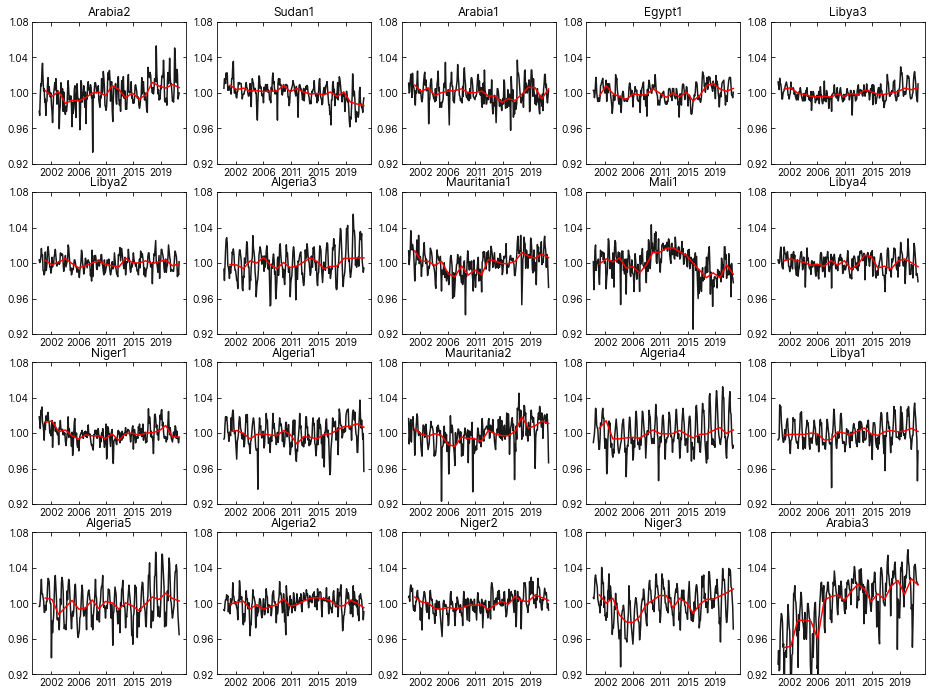

In [37]:
pics_modis_red_mvc=np.zeros((np.int64(pics_modis_red.shape[0]/2), pics_modis_red.shape[1]))
for i in range(int(pics_modis_red.shape[0]/2)):
    pics_modis_red_mvc[i, :] = np.nanmean(pics_modis_red[2*i:2*i+2, :], axis=0)
pics_modis_red_mvc_year=np.zeros((np.int64(pics_modis_red_mvc.shape[0] /12), pics_modis_red_mvc.shape[1]))
for i in range(int(pics_modis_red_mvc_year.shape[0])):
    pics_modis_red_mvc_year[i, :] = np.median(pics_modis_red_mvc[12*i:12*i+12, :], axis=0)

pics_modis_red_mvc_year_normalized=pics_modis_red_mvc_year/np.mean(pics_modis_red_mvc_year, axis=0)
pics_modis_red_mvc_normalized=pics_modis_red_mvc/np.mean(pics_modis_red_mvc, axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

ax=axs.flatten()
for i in range(pics_modis_red_mvc_year_normalized.shape[1]):
    n_months = pics_modis_red_mvc_normalized.shape[0]
    n_years = pics_modis_red_mvc_year_normalized.shape[0]
    ax[i].plot(pd.date_range("2001-1-1", periods=n_months, freq="M"), pics_modis_red_mvc_normalized[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("2001-1-1", periods=n_years, freq="Y"), pics_modis_red_mvc_year_normalized[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(0.92, 1.08)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "Normalized_modis_red_PICS_modis_red_modvalml_filled_nan_mean.pdf"))


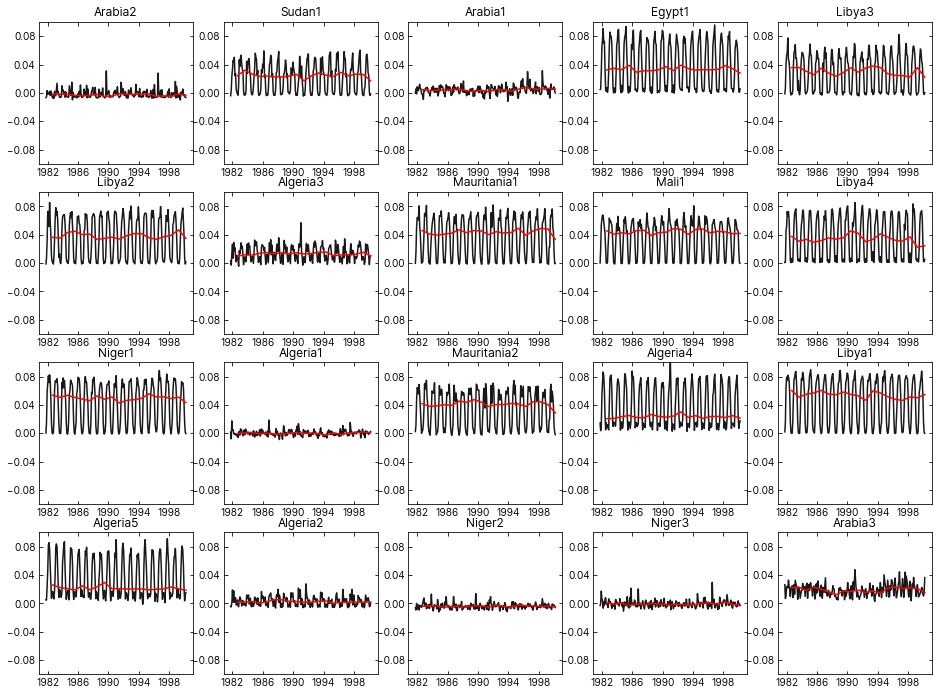

In [38]:
pics_sif_mvc=np.zeros((np.int64(pics_sif.shape[0]/2), pics_sif.shape[1]))
for i in range(int(pics_sif.shape[0]/2)):
    pics_sif_mvc[i, :] = np.nanmean(pics_sif[2*i:2*i+2, :], axis=0)
pics_sif_mvc_year=np.zeros((np.int64(pics_sif_mvc.shape[0] /12), pics_sif_mvc.shape[1]))
for i in range(int(pics_sif_mvc_year.shape[0])):
    pics_sif_mvc_year[i, :] = np.median(pics_sif_mvc[12*i:12*i+12, :], axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

n_months = pics_sif_mvc.shape[0]
n_years = pics_sif_mvc_year.shape[0]
n_sites = pics_sif_mvc_year.shape[1]

ax = axs.flatten()
for i in range(n_sites):
    ax[i].plot(pd.date_range("1982-1-1", periods=n_months, freq="M"), pics_sif_mvc[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("1982-1-1", periods=n_years, freq="Y"), pics_sif_mvc_year[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "SIF_PICS_avhrr_sif_modvalml_filled_nan_mean.pdf"))


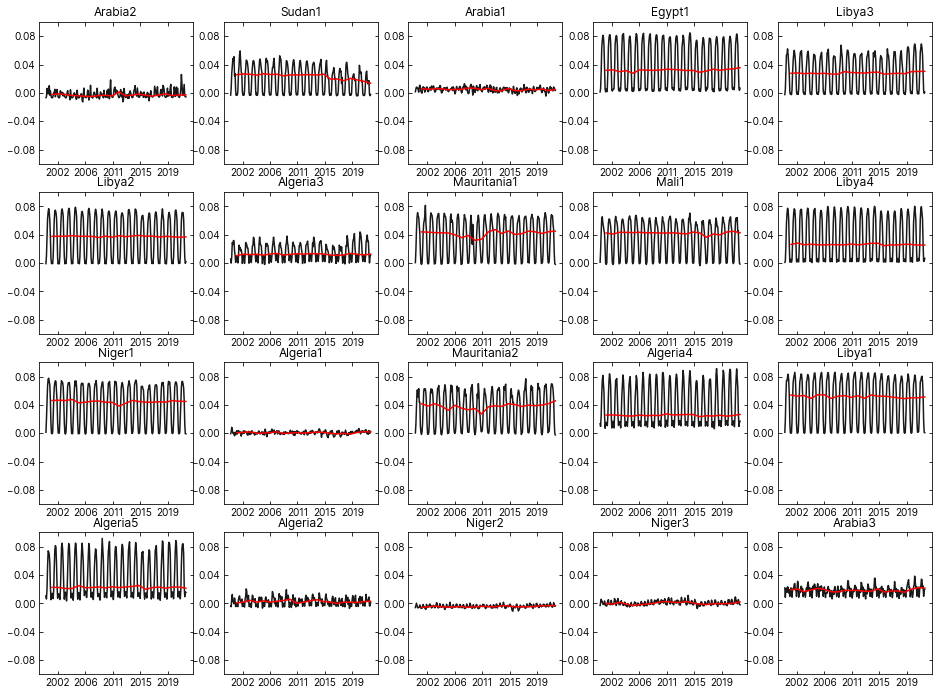

In [39]:
pics_modis_sif_mvc=np.zeros((np.int64(pics_modis_sif.shape[0]/2), pics_modis_sif.shape[1]))
for i in range(int(pics_modis_sif.shape[0]/2)):
    pics_modis_sif_mvc[i, :] = np.nanmean(pics_modis_sif[2*i:2*i+2, :], axis=0)
pics_modis_sif_mvc_year=np.zeros((np.int64(pics_modis_sif_mvc.shape[0] /12), pics_modis_sif_mvc.shape[1]))
for i in range(int(pics_modis_sif_mvc_year.shape[0])):
    pics_modis_sif_mvc_year[i, :] = np.median(pics_modis_sif_mvc[12*i:12*i+12, :], axis=0)

fig, axs=plt.subplots(4,5, figsize=(16,12))

n_months = pics_modis_sif_mvc.shape[0]
n_years = pics_modis_sif_mvc_year.shape[0]
n_sites = pics_modis_sif_mvc_year.shape[1]

ax = axs.flatten()
for i in range(n_sites):
    ax[i].plot(pd.date_range("2001-1-1", periods=n_months, freq="M"), pics_modis_sif_mvc[:,i], c="k", alpha=0.9)
    ax[i].plot(pd.date_range("2001-1-1", periods=n_years, freq="Y"), pics_modis_sif_mvc_year[:,i], c="red")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter("%Y")) 
    ax[i].xaxis.set_major_locator(MaxNLocator(6)) 
    ax[i].yaxis.set_major_locator(MaxNLocator(5)) 
    ax[i].set_ylim(-0.1, 0.1)
    ax[i].tick_params(right=True, top=True)
    ax[i].set_title(PICS.site[i])

plt.savefig(os.path.join(fig_dir, "SIF_PICS_modis_sif_modvalml_filled_nan_mean.pdf"))

In [40]:
area_weight=xr.open_dataset(os.path.join(VECTOR_DIR, "CMG_0.05Degree_Area_WGS84.nc")).area.values

NAN_MASK = np.isnan(xr.open_dataset(LCSIF_AVHRR_PERIOD_FILE_LIST[0]).sif_clear_daily.values[0])

In [ ]:
sif_avhrr_weighted_spatial_annual_mean_list=[]
for YEAR in tqdm(np.array(LCSIF_AVHRR_PERIOD_FILE_LIST).reshape(-1,24)):
    year_list=[]
    for i in range(12):
        first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
        first_half_month[NAN_MASK]=np.nan
        second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
        second_half_month[NAN_MASK]=np.nan
        year_list.append(np.nanmean(np.stack([first_half_month, second_half_month]), axis=0))
    year_stack = np.stack(year_list)
    year_mean = np.nanmean(year_stack, axis=0)
    year_weighted = np.nansum(year_mean * area_weight) / np.nansum(area_weight[np.invert(np.isnan(year_mean * area_weight))])
    sif_avhrr_weighted_spatial_annual_mean_list.append(year_weighted)

In [ ]:
sif_modis_weighted_spatial_annual_mean_list=[]
for YEAR in tqdm(np.array(LCSIF_MODIS_PERIOD_FILE_LIST).reshape(-1,24)):
    year_list=[]
    for i in range(12):
        first_half_month = xr.open_dataset(YEAR[i*2]).sif_clear_daily.values[0]
        first_half_month[NAN_MASK]=np.nan
        second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_clear_daily.values[0]
        second_half_month[NAN_MASK]=np.nan
        year_list.append(np.nanmean(np.stack([first_half_month, second_half_month]), axis=0))
    year_stack = np.stack(year_list)
    year_mean = np.nanmean(year_stack, axis=0)
    year_weighted = np.nansum(year_mean * area_weight) / np.nansum(area_weight[np.invert(np.isnan(year_mean * area_weight))])
    sif_modis_weighted_spatial_annual_mean_list.append(year_weighted)


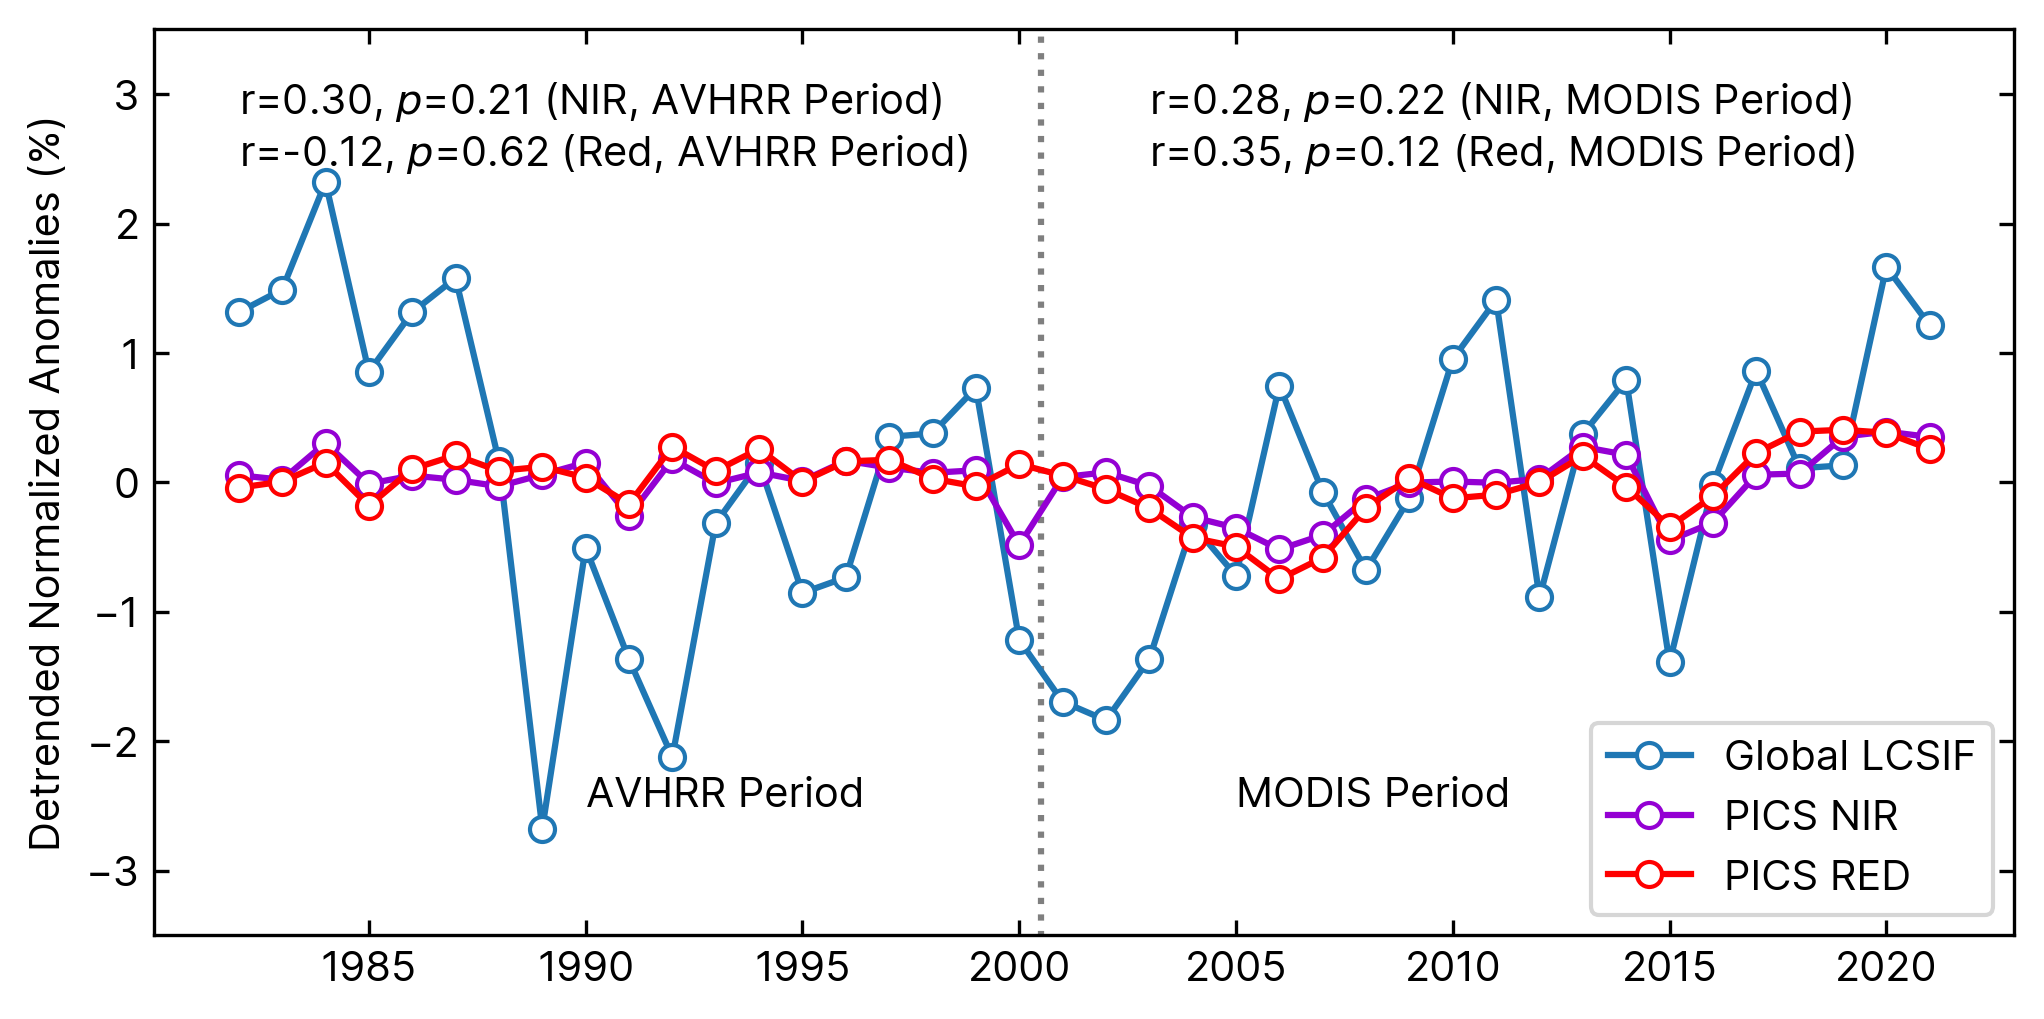

In [75]:
plt.figure(figsize=(8,4), dpi=300)

pics_nir_mvc_year_combined = np.vstack([pics_nir_mvc_year, pics_modis_nir_mvc_year])

pics_nir_mvc_year_combined_normalized = pics_nir_mvc_year_combined / np.mean(pics_nir_mvc_year_combined, axis=0)

pics_red_mvc_year_combined = np.vstack([pics_red_mvc_year, pics_modis_red_mvc_year])

pics_red_mvc_year_combined_normalized = pics_red_mvc_year_combined / np.mean(pics_red_mvc_year_combined, axis=0)

sif_year_combined = np.concatenate([sif_avhrr_weighted_spatial_annual_mean_list, sif_modis_weighted_spatial_annual_mean_list])

pics_nir_detrend=detrend(np.mean(pics_nir_mvc_year_combined_normalized, axis=1))
pics_red_detrend=detrend(np.mean(pics_red_mvc_year_combined_normalized, axis=1))

sif_detrend=detrend(sif_year_combined/np.mean(sif_year_combined))

plt.plot([2000.5, 2000.5], [-5, 5], "k:", alpha=0.5)
plt.plot(np.arange(1982,2022), sif_detrend * 100, "-o", markerfacecolor="white", label="Global LCSIF")
plt.plot(np.arange(1982,2022), pics_nir_detrend * 100 , "-o", markerfacecolor="white", c="darkviolet", label= "PICS NIR")
plt.plot(np.arange(1982,2022), pics_red_detrend * 100 , "-o", markerfacecolor="white", c="red", label="PICS RED")
plt.ylim(-3, 3)

plt.text(1982, 2.45, "r=-0.12, $p$=0.62 (Red, AVHRR Period)", fontsize=10)
plt.text(1982, 2.85, "r=0.30, $p$=0.21 (NIR, AVHRR Period)", fontsize=10)
plt.text(2003, 2.45, "r=0.35, $p$=0.12 (Red, MODIS Period)", fontsize=10)
plt.text(2003, 2.85, "r=0.28, $p$=0.22 (NIR, MODIS Period)", fontsize=10)

plt.text(1990, -2.5, "AVHRR Period")
plt.text(2005, -2.5, "MODIS Period")

plt.ylim(-3.5, 3.5)
plt.ylabel("Detrended Normalized Anomalies (%)")
plt.tick_params(right=True, top=True)
plt.legend(loc="lower right")
plt.savefig(os.path.join(fig_dir, "PICSNIR_GLOBALLCSIF_Detrended_Normalzied_Bias_nan_mean.pdf"))

In [45]:
linregress(pics_red_detrend[0:19], sif_detrend[0:19])

LinregressResult(slope=-1.2660833486614103, intercept=0.0014111036947575164, rvalue=-0.12020908858640243, pvalue=0.6239988899498223, stderr=2.5359449023815133, intercept_stderr=0.003656519019055774)

In [44]:
linregress(pics_nir_detrend[0:19], sif_detrend[0:19])

LinregressResult(slope=2.408440953409359, intercept=-0.00030007814041030324, rvalue=0.304344353919356, pvalue=0.20520627924736473, stderr=1.828266837890735, intercept_stderr=0.0030393386317006904)

In [46]:
linregress(pics_nir_detrend[19:], sif_detrend[19:])

LinregressResult(slope=1.3192581006627147, intercept=-3.621603723007454e-05, rvalue=0.347396854289729, pvalue=0.12282911451507922, stderr=0.8169574424084128, intercept_stderr=0.002170770883978164)

In [47]:
linregress(pics_red_detrend[19:], sif_detrend[19:])

LinregressResult(slope=0.8836766938547307, intercept=0.00019674501013787168, rvalue=0.27809296961167757, pvalue=0.2222359998234135, stderr=0.700242473322124, intercept_stderr=0.0022625222717234405)

In [50]:
sif_modis_detrend.shape

(21,)

In [51]:
np.arange(2000,2022).shape

(22,)

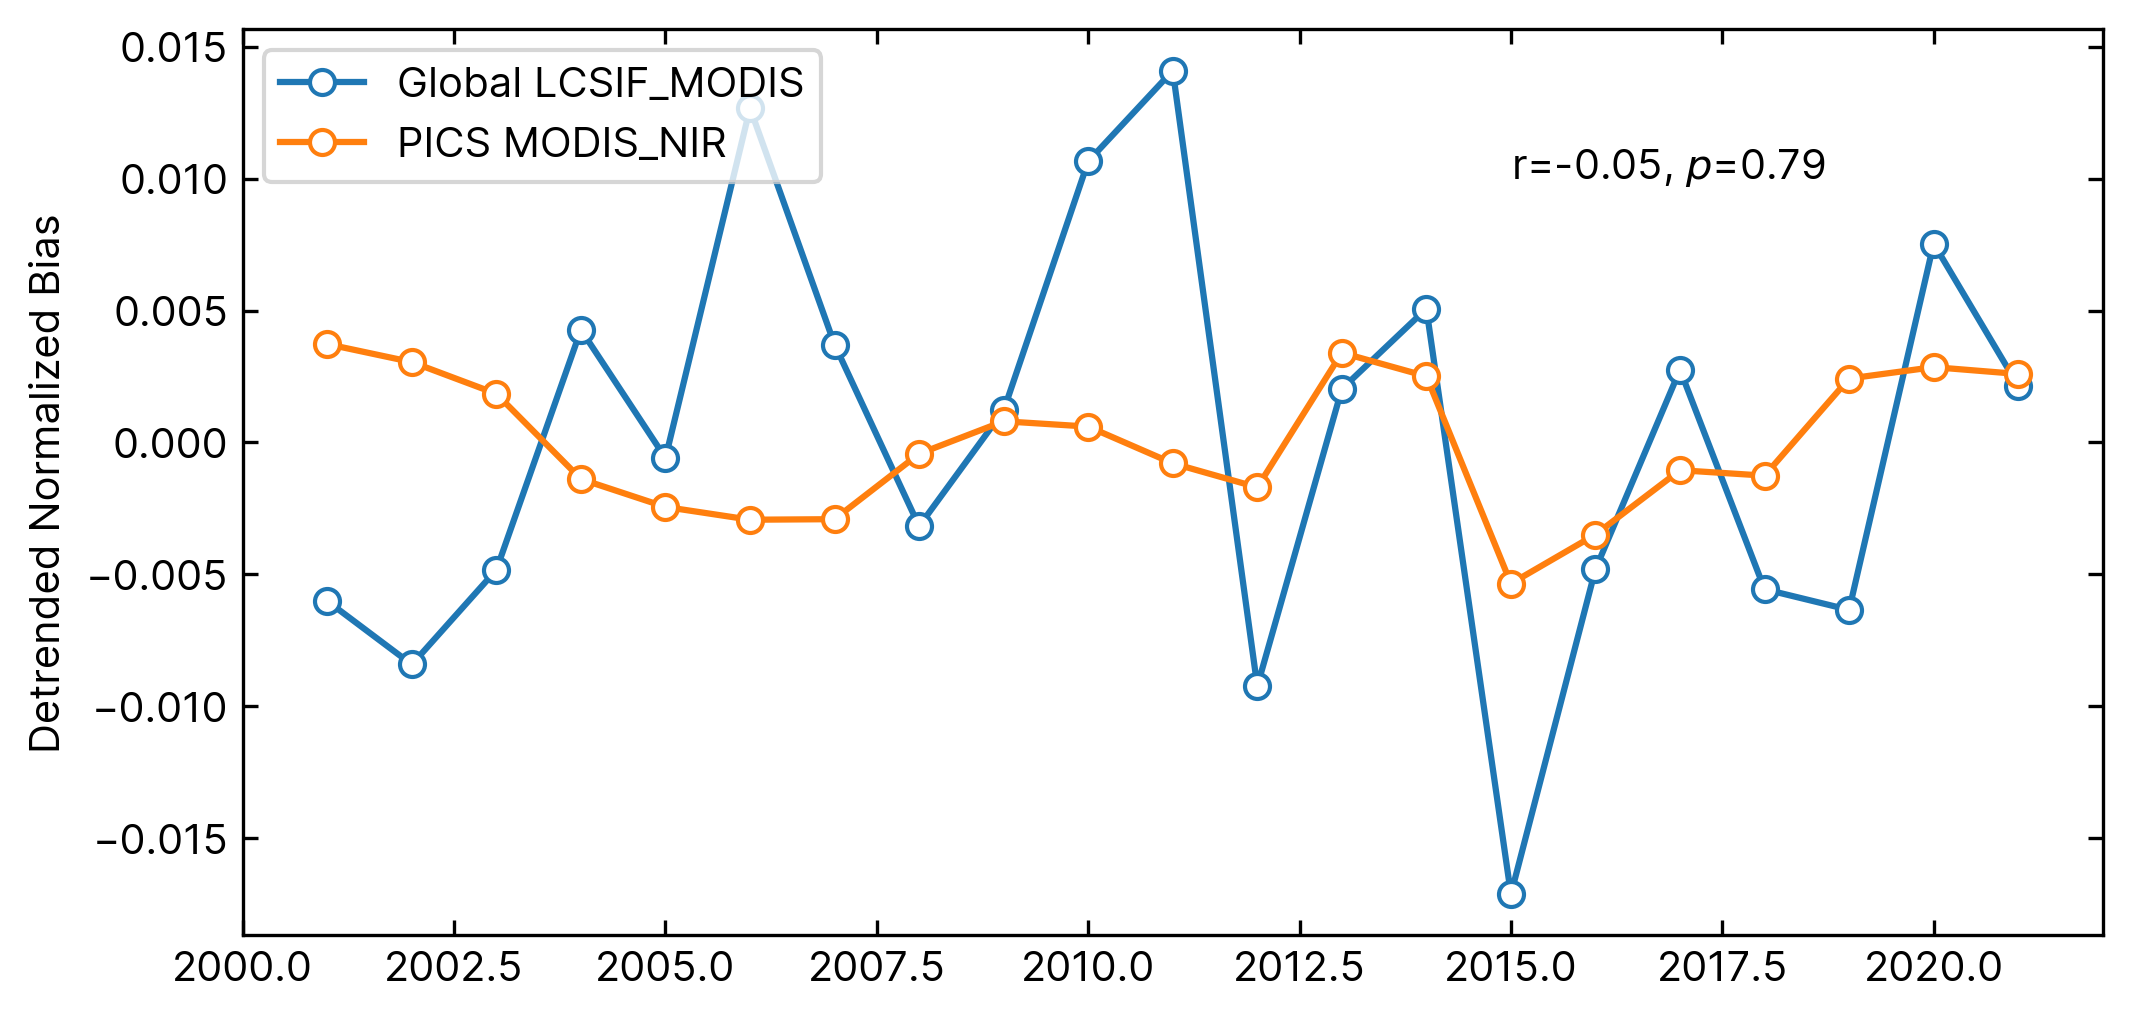

In [63]:
plt.figure(figsize=(8,4), dpi=300)
pics_modis_nir_detrend=detrend(np.median(pics_modis_nir_mvc_year_normalized, axis=1))
sif_modis_detrend=detrend(sif_modis_weighted_spatial_annual_mean_list/np.mean(sif_modis_weighted_spatial_annual_mean_list))
plt.plot(np.arange(2001,2022), sif_modis_detrend, "-o", markerfacecolor="white", label="Global LCSIF_MODIS")
plt.plot(np.arange(2001,2022), pics_modis_nir_detrend , "-o", markerfacecolor="white", label="PICS MODIS_NIR")
plt.text(2015, 0.01, "r=-0.05, $p$=0.79")
#plt.text(2006, 0.042, "r=0.66, $p$<0.01 (1982-2021)")
plt.ylabel("Detrended Normalized Bias")
plt.tick_params(right=True, top=True)
plt.legend(loc="upper left")
plt.savefig(os.path.join(fig_dir, "PICSMODIS_NIR_GLOBALLCSIF_MODIS_Detrended_Normalzied_Bias_nan_mean.pdf"))

In [53]:
linregress(pics_modis_nir_detrend, sif_modis_detrend)

LinregressResult(slope=0.3449603100475877, intercept=1.4641076505392506e-16, rvalue=0.11620373071550193, pvalue=0.6159419070440881, stderr=0.6764256608389198, intercept_stderr=0.0017367595073113546)

In [59]:
np.mean(pics_nir_mvc_year_combined_normalized, axis=1).shape

(40,)

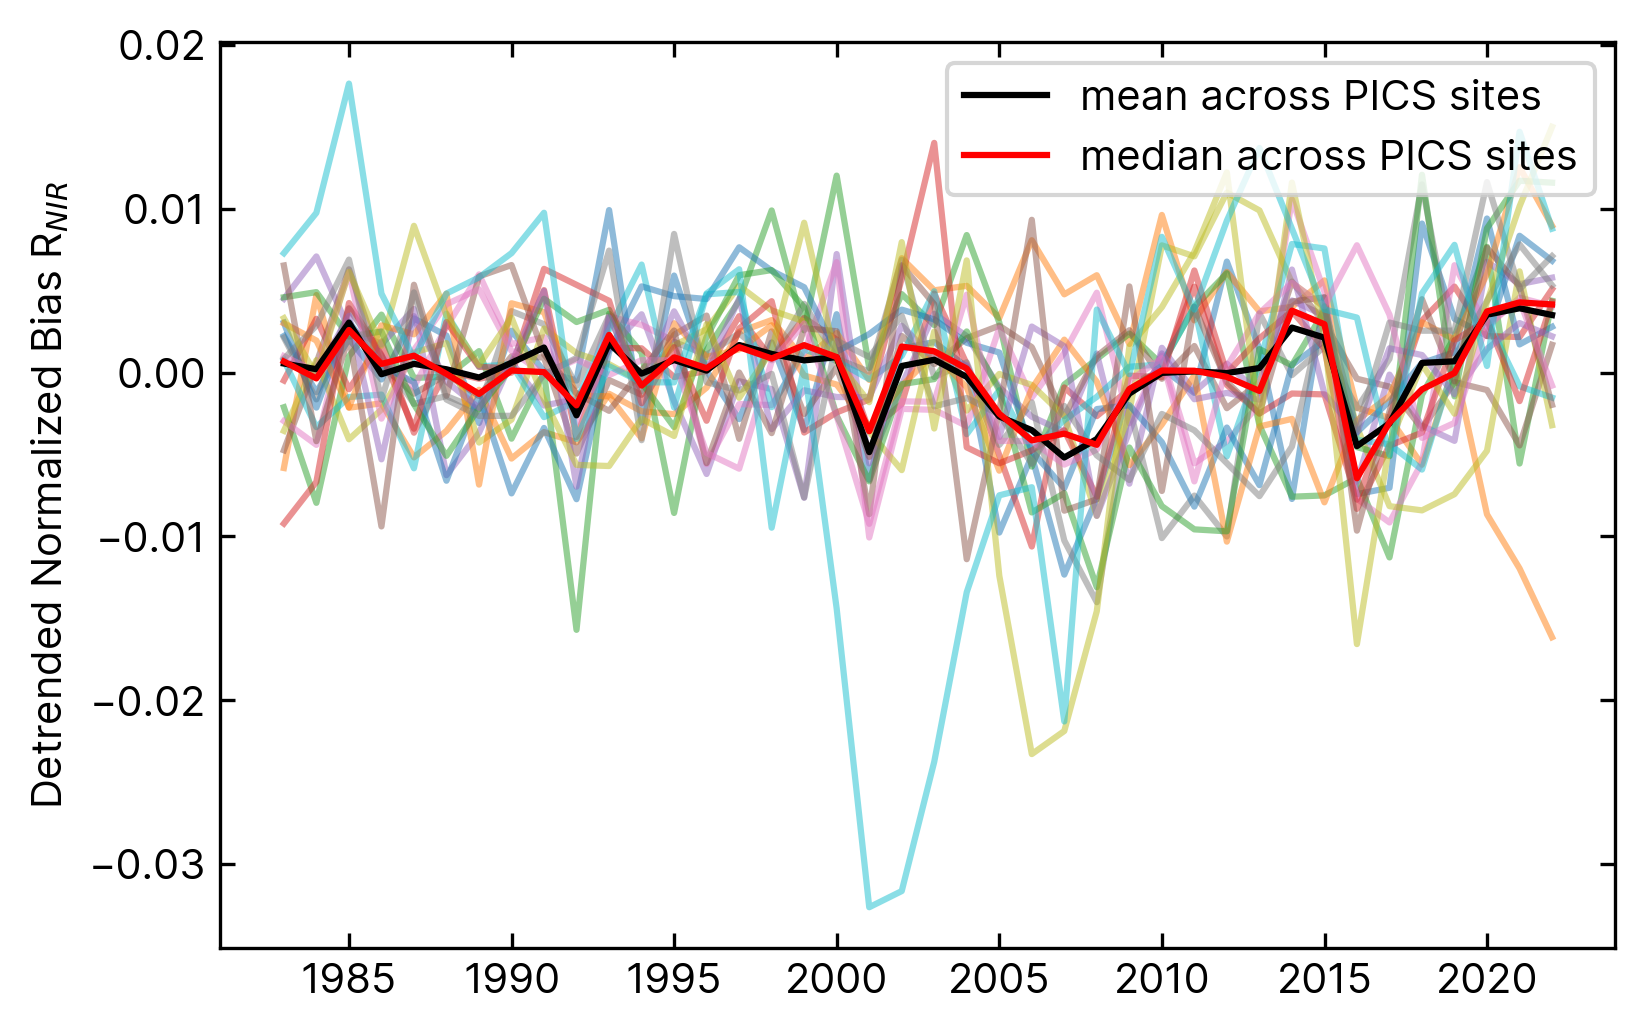

In [61]:
plt.figure(dpi=300)
for ele in pics_nir_mvc_year_combined_normalized.T:
    plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(ele), alpha=0.5)
plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(np.mean(pics_nir_mvc_year_combined_normalized, axis=1)), c="k", label="mean across PICS sites")
plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(np.median(pics_nir_mvc_year_combined_normalized, axis=1)), c="red", label="median across PICS sites")

plt.ylabel("Detrended Normalized Bias R$_{NIR}$")
plt.tick_params(right=True, top=True)
plt.legend(loc="upper right")
plt.savefig(os.path.join(fig_dir, "NIR_PICS_detrended_normalized_All_sites_mean_median_nan_mean.pdf"))


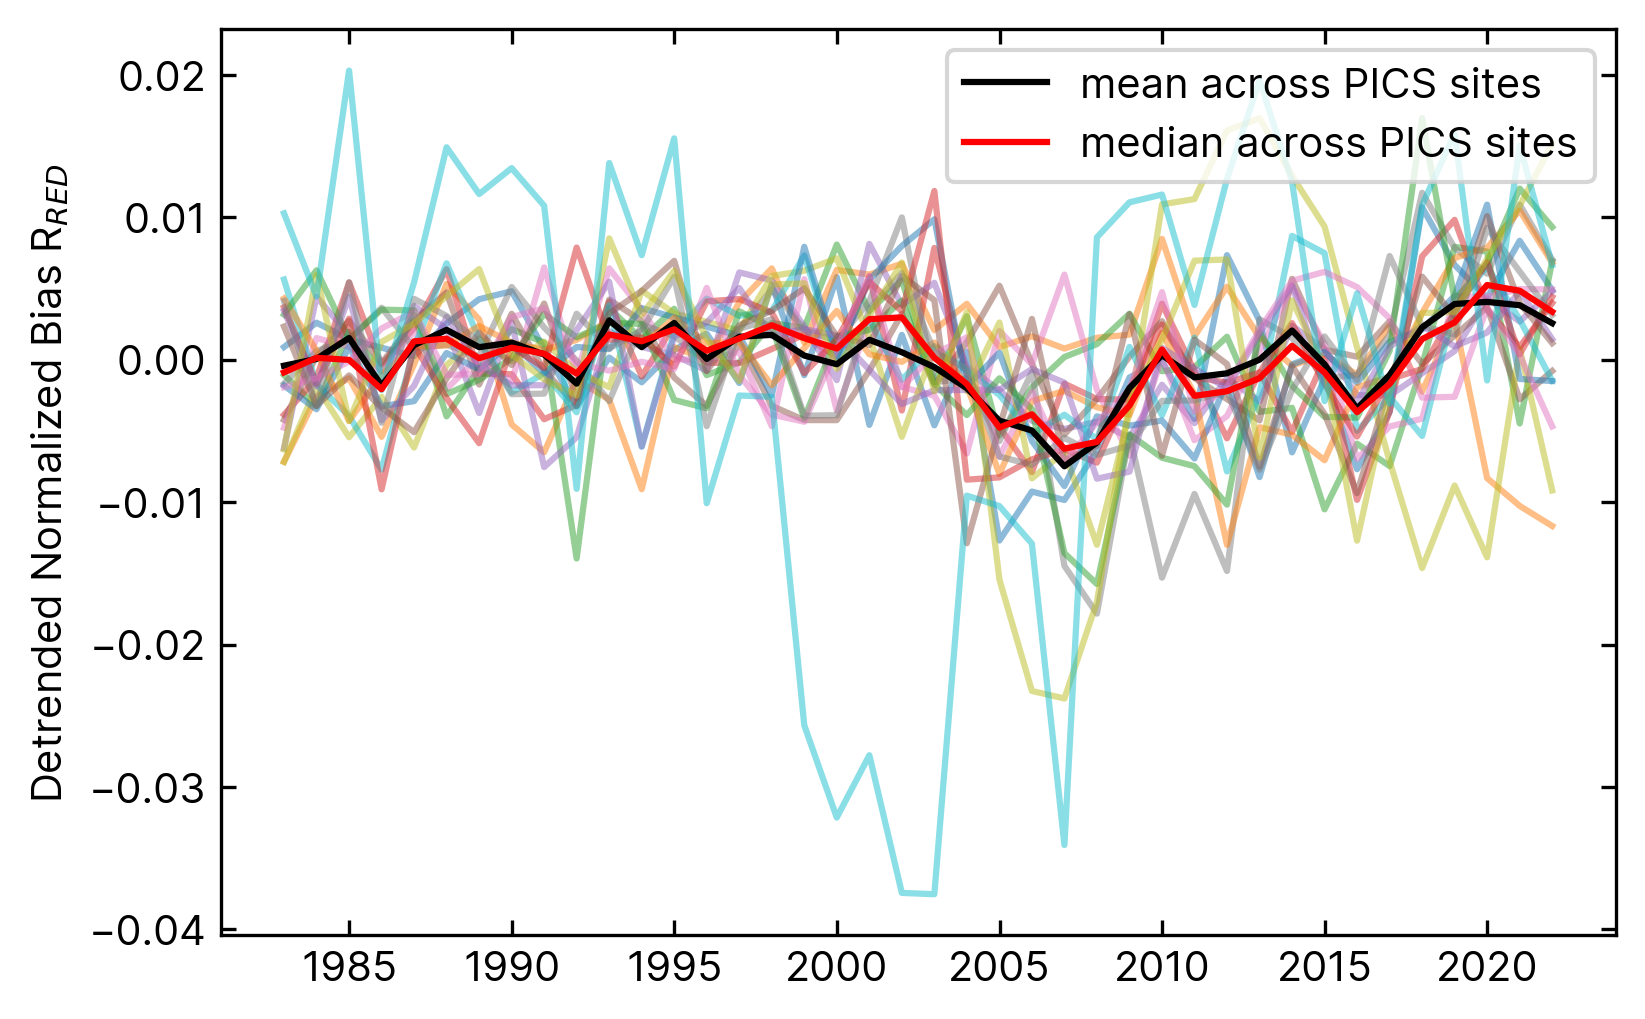

In [62]:
plt.figure(dpi=300)
for ele in pics_red_mvc_year_combined_normalized.T:
    plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(ele), alpha=0.5)
plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(np.mean(pics_red_mvc_year_combined_normalized, axis=1)), c="k", label="mean across PICS sites")
plt.plot(pd.date_range("1982-1-1", periods=40, freq="Y"), detrend(np.median(pics_red_mvc_year_combined_normalized, axis=1)), c="red", label="median across PICS sites")

plt.ylabel("Detrended Normalized Bias R$_{RED}$")
plt.tick_params(right=True, top=True)
plt.legend(loc="upper right")
plt.savefig(os.path.join(fig_dir, "RED_PICS_detrended_normalized_All_sites_mean_median_nan_mean.pdf"))


In [ ]:
for ele in pics_modis_nir_mvc_year_normalized.T:
    plt.plot(pd.date_range("2000-1-1", periods=22, freq="Y"), detrend(ele), alpha=0.5)
plt.plot(pd.date_range("2000-1-1", periods=22, freq="Y"), detrend(np.mean(pics_modis_nir_mvc_year_normalized, axis=1)), c="k", label="mean across PICS sites")
plt.plot(pd.date_range("2000-1-1", periods=22, freq="Y"), detrend(np.median(pics_modis_nir_mvc_year_normalized, axis=1)), c="red", label="median across PICS sites")

plt.ylabel("Detrended Normalized Bias R$_{MODIS_NIR}$")
plt.tick_params(right=True, top=True)
plt.legend(loc="upper right")
plt.savefig(os.path.join(fig_dir, "MODIS_NIR_PICS_detrended_normalized_All_sites_mean_median_nan_mean.pdf"))


In [ ]:
pics_ndvi = (pics_nir - pics_red)/(pics_nir + pics_red)
pics_ndvi_mvc=np.zeros((480, 20))
for i in range(int(pics_ndvi.shape[0]/2)):
    pics_ndvi_mvc[i, :] = np.nanmean(pics_ndvi[2*i:2*i+2, :], axis=0)
    
pics_ndvi_mvc_year=np.zeros((40, 20))
for i in range(int(pics_ndvi_mvc_year.shape[0])):
    pics_ndvi_mvc_year[i, :] = np.median(pics_ndvi_mvc[12*i:12*i+12, :], axis=0)

pics_ndvi_mvc_year_normalized=pics_ndvi_mvc_year/np.mean(pics_ndvi_mvc_year, axis=0)
pics_ndvi_mvc_normalized=pics_ndvi_mvc/np.mean(pics_ndvi_mvc, axis=0)

In [ ]:
plt.figure(figsize=(8,4))
pics_ndvi_detrend=detrend(np.median(pics_ndvi_mvc_year_normalized, axis=1))
sif_detrend=detrend(sif_weighted_spatial_annual_mean_list/np.mean(sif_weighted_spatial_annual_mean_list))
plt.plot(np.arange(1982,2022), sif_detrend, "-o", markerfacecolor="white", label="Global LCSIF")
plt.plot(np.arange(1982,2022), pics_ndvi_detrend , "-o", markerfacecolor="white", label="PICS NDVI")
#plt.text(2006, 0.052, "r=0.85, $p$<0.01 (1982-1999)")
#plt.text(2006, 0.042, "r=0.67, $p$<0.01 (1982-2021)")
plt.ylabel("Detrended Normalized Bias")
plt.tick_params(right=True, top=True)
plt.legend(loc="upper left")

In [ ]:
pics_red_detrend=detrend(np.median(pics_red_mvc_year_normalized, axis=1))

plt.plot(pics_ndvi_detrend, label="PICS NDVI")
plt.plot(pics_nir_detrend)
plt.plot(pics_red_detrend)

In [ ]:
SIF_MODIS_YEAR_OUT_DIR_V5_LIST=[]
for YEAR in sorted(os.listdir(SIF_MODIS_OUT_DIR_V5)):
    SIF_YEAR_LIST=[]
    for FILE in sorted(os.listdir(os.path.join(SIF_MODIS_OUT_DIR_V5, YEAR))):
        SIF_YEAR_LIST.append(os.path.join(SIF_MODIS_OUT_DIR_V5, YEAR, FILE))
    SIF_MODIS_YEAR_OUT_DIR_V5_LIST.append(SIF_YEAR_LIST)


In [ ]:
sif_modis_weighted_spatial_annual_mean_list=[]
for YEAR in tqdm(SIF_MODIS_YEAR_OUT_DIR_V5_LIST):
    year_list=[]
    for i in range(12):
        first_half_month = xr.open_dataset(YEAR[i*2]).sif_modis_clear_daily.values[0]
        second_half_month = xr.open_dataset(YEAR[i*2 + 1]).sif_modis_clear_daily.values[0]
        year_list.append(np.nanmean(np.stack([first_half_month, second_half_month]), axis=0))
    year_stack = np.stack(year_list)
    year_mean = np.nanmean(year_stack, axis=0)
    year_weighted = np.nansum(year_mean * area_weight) / np.nansum(area_weight[np.invert(np.isnan(year_mean * area_weight))])
    sif_modis_weighted_spatial_annual_mean_list.append(year_weighted)